### Import modules

In [7]:
import os
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
import math
from sklearn.multioutput import MultiOutputRegressor
import sklearn.neural_network as skl_nn

from sklearn.metrics import mean_squared_error
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res =[rmse(m.predict(X_train_scaled),y_train),rmse(m.predict(X_test_scaled),y_test),m.score(X_train_scaled,y_train),m.score(X_test_scaled,y_test)]
    if hasattr(m,'oob_score_'):res.append(m.oob_score_)
    print(res)

In [8]:
path='/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/'
pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/ProcessedDataForGroup/'

# Building Surrogates

In [9]:
# Tau13 vertical profile, color a function of cases (one hour average)

DX=[12,18,24,30,36,48]
#DX=[6,12,18,24,30,36]!!!!!!!!!!!!!!!!!!!!!!!!!!!! Cannot process DX=6 here, not enough memmory processed manually

DZ=['2.0','2.4','3.0','4.0','4.5','5.0','6.0','7.2','7.5','8.0','9.0','10.0','12.0','15.0','18.0']

case_colormap = plt.cm.plasma(np.linspace(0, 1, np.int(0.5*len(DX)*len(DZ)) ))

dx_list=[]
dz_list=[]
f_list=[]
pf_list=[]

case=[]
p=0
q=0
for dx in DX:
    p=p+1
    for dz in DZ:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        pdata_3D = f'pdata_3D_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'

        if os.path.exists(path+folder):
            if os.path.exists(pdata_loc + pdata_3D):
                #print(folder)
                q=q+1
                dx_list.append(dx)
                dz_list.append(dz)
                img=xr.open_dataset(pdata_loc + f'time_average_spectra_{delta_t}_{folder}.nc')
                img['U_p_norm_power'] = img.U_p * img.frequency
                img['W_p_norm_power'] = img.W_p * img.frequency
                f_list.append(img.frequency)
                pf_list.append(img.U_p_norm_power.isel(XTIME = 0, nz = 0))


/g/g92/mgf/my_personal_env/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/g92/mgf/my_personal_env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [10]:
dx_np=np.array(dx_list)
dz_np=np.array(dz_list)
f_np=np.array(f_list)
pf_np=np.array(pf_list)

In [11]:
l=[]
for i in range(len(f_list)):
    l.append(len(f_list[i]))
longest=np.max(l)

pca_data=np.zeros([35,2,longest])

In [12]:

def ext_func(data,new_length): 
    old_indices = np.arange(0,len(data))
    new_indices = np.linspace(0,len(data)-1,new_length)
    spl = UnivariateSpline(old_indices,data,k=3,s=0)
    return spl(new_indices)

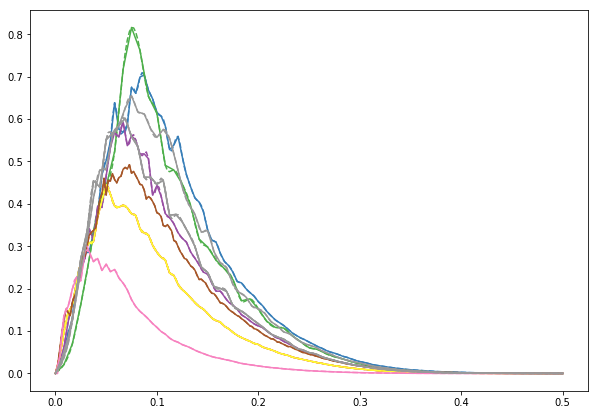

In [13]:
#Splines to make length consistent

plt.figure(figsize=(10,7))
case_colormap = plt.cm.Set1(np.linspace(0, 5, len(f_list) ))


for i in range(len(f_list)):
    df1=f_list[i].to_dataframe().iloc[:,-1].reset_index(drop=True)
    pca_data[i,0,:]=ext_func(df1,longest)
    df2=pf_list[i].to_dataframe().iloc[:,-1].reset_index(drop=True)
    pca_data[i,1,:]=ext_func(df2,longest)


for i in range(10):#(len(f_list)):
    df1 = f_list[i].to_dataframe().iloc[:,-1].reset_index(drop=True)
    df2 = pf_list[i].to_dataframe().iloc[:,-1].reset_index(drop=True)
    plt.plot(df1,df2,'-',color=case_colormap[i])
    plt.plot(ext_func(df1,longest),ext_func(df2,longest),'--',color=case_colormap[i])

In [14]:
print(pca_data.shape)

#Now we can drop the frequencies (x-axis) beause they are all the same

pca_data=pca_data[:,1,:]

print(pca_data.shape)

(35, 2, 241)
(35, 241)


In [15]:
pca_reductor = PCA()#PCA(0.95)
pca_reductor.fit(pca_data)

PCA()

components= 35


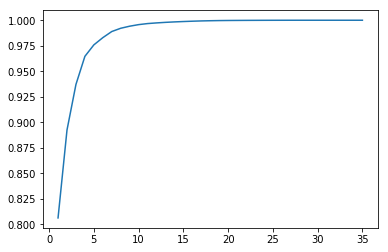

In [16]:
components=len(pca_reductor.components_)
print('components=', components)
plt.figure()
plt.plot(np.linspace(1,components,components),np.cumsum(pca_reductor.explained_variance_ratio_)) #(ratio 4 components)

/collab/usr/gapps/python/build/spack-toss3.3/opt/spack/linux-rhel7-x86_64/gcc-4.9.3/python-3.7.2-asydydmavj2puklmx5t6cu3ruzmg2b3a/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


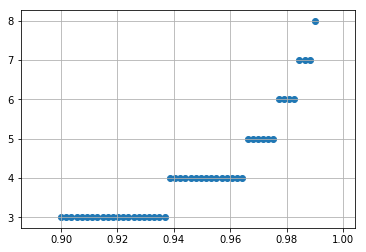

In [17]:
explained_variance=np.linspace(0.9,0.99,50)
components=[]
for i in explained_variance:
    pca_reductor = PCA(i)
    pca_reductor.fit(pca_data)
    components.append(len(pca_reductor.components_))

plt.scatter(explained_variance,components)
plt.grid('on')

components= 8


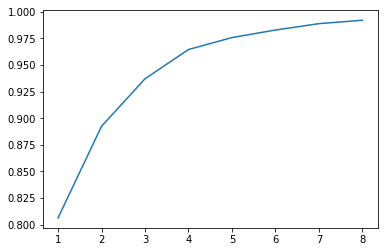

In [18]:
pca_reductor = PCA(0.99)
pca_reductor.fit(pca_data)
components=len(pca_reductor.components_)
print('components=', components)
plt.figure()
plt.plot(np.linspace(1,components,components),np.cumsum(pca_reductor.explained_variance_ratio_)) #(ratio 4 components)

In [19]:
reduced_output_data=pca_reductor.transform(pca_data)

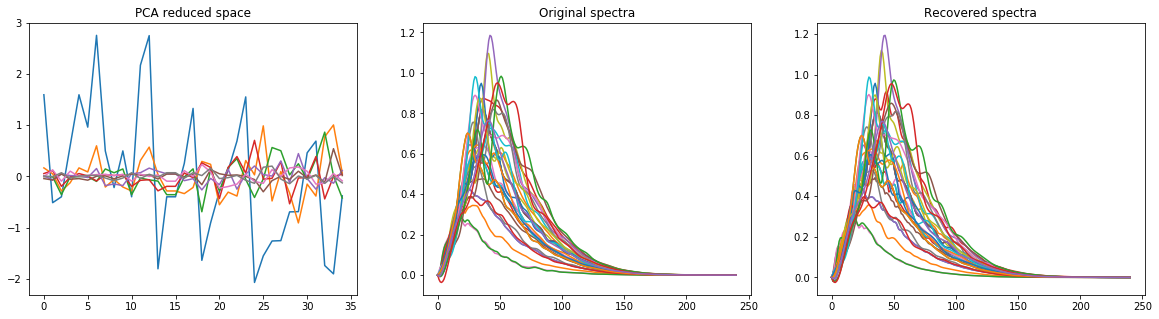

In [65]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title('PCA reduced space')
a=plt.plot(reduced_output_data)
plt.subplot(1,3,2)
plt.title('Original spectra')
b=plt.plot(pca_reductor.inverse_transform(reduced_output_data).T)
plt.subplot(1,3,3)
plt.title('Recovered spectra')
b=plt.plot(pca_data.T)

In [21]:
input_data=np.array([dx_np,dz_np]).astype('float64').T

In [137]:
X, y = input_data,reduced_output_data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print([X_train.shape,y_train.shape])
[X_test.shape,y_test.shape]

[(28, 2), (28, 8)]


[(7, 2), (7, 8)]

In [159]:
train_test_split?

In [138]:
reduced_output_data.shape

(35, 8)

In [139]:
inputs_scaler=MinMaxScaler()

X_train_scaled= inputs_scaler.fit_transform(X_train)
X_test_scaled= inputs_scaler.transform(X_test)


outputs_scaler=MinMaxScaler()

y_train_scaled= outputs_scaler.fit_transform(y_train)
y_test_scaled= outputs_scaler.transform(y_test)

In [140]:
y_train_scaled.shape

(28, 8)

In [68]:
RandomForestRegressor?

R2 train:0.8319332029601111
R2 test:-0.8550617289257334
RMSE: 0.283798


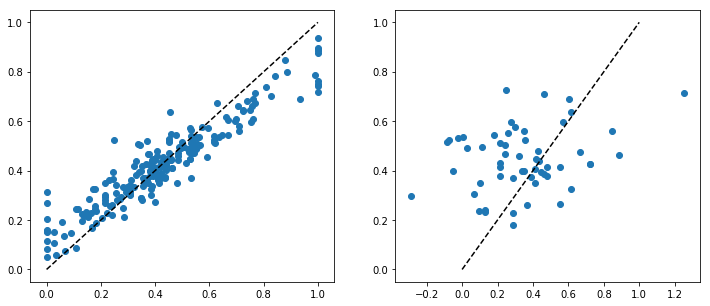

In [141]:
# Random Forest Custom values

RF_model=RandomForestRegressor(
    n_estimators=50,
    criterion='mse',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
                               
RF_model.fit(X_train_scaled,y_train_scaled)
print(f'R2 train:{RF_model.score(X_train_scaled,y_train_scaled)}')


preds = RF_model.predict(X_test_scaled)
print(f'R2 test:{RF_model.score(X_test_scaled,y_test_scaled)}')
rmse = np.sqrt(mean_squared_error(y_test_scaled, preds))
print("RMSE: %f" % (rmse))

lb=np.min(y_train_scaled);ub=np.max(y_train_scaled)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train_scaled,RF_model.predict(X_train_scaled))
plt.plot([lb,ub],[lb,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test_scaled,RF_model.predict(X_test_scaled))
plt.plot([lb,ub],[lb,ub],'k--')

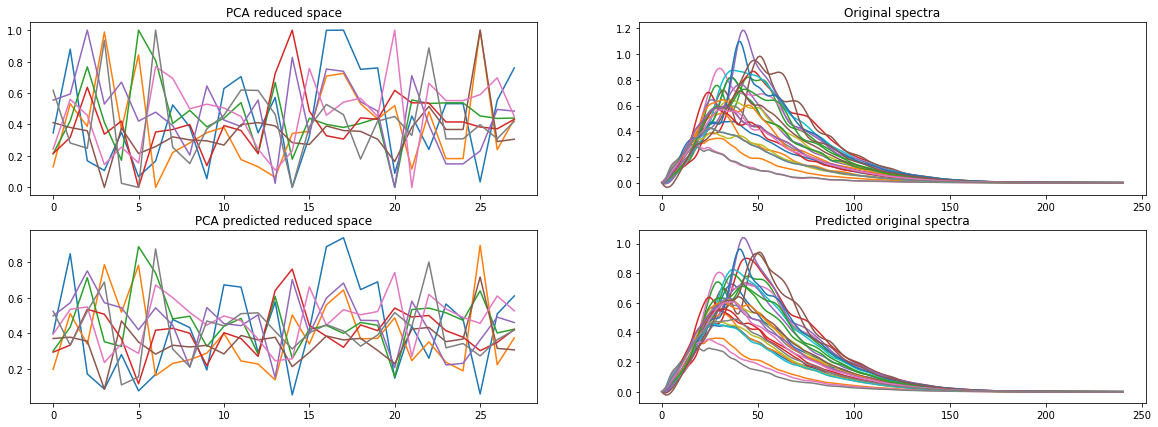

In [142]:
#Training data


plt.figure(figsize=(20,7))
plt.subplot(2,2,1)
plt.title('PCA reduced space')
a=plt.plot(y_train_scaled)

plt.subplot(2,2,2)
plt.title('Original spectra')
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T)

plt.subplot(2,2,3)
plt.title('PCA predicted reduced space')
pred_train=RF_model.predict(X_train_scaled)
a=plt.plot(pred_train)

plt.subplot(2,2,4)
plt.title('Predicted original spectra')
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T)

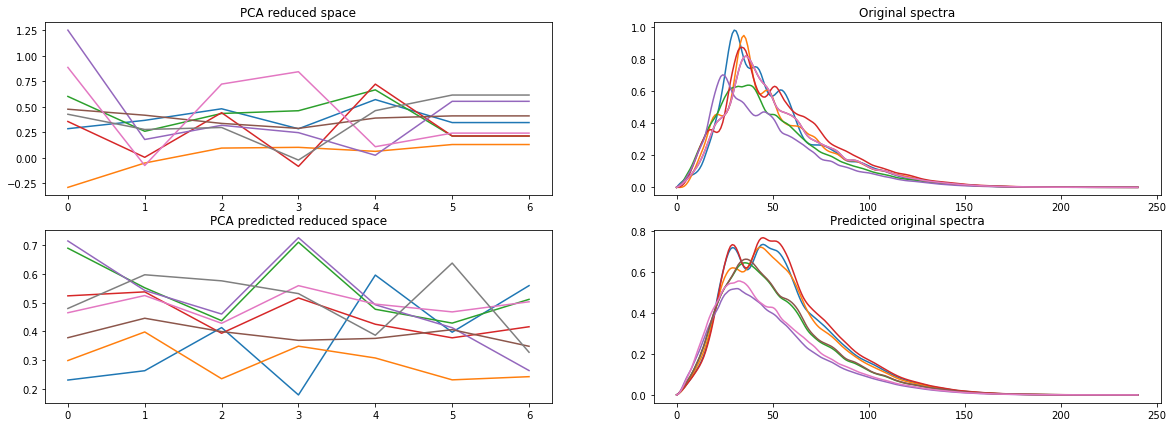

In [144]:
#Test data


plt.figure(figsize=(20,7))
plt.subplot(2,2,1)
plt.title('PCA reduced space')
a=plt.plot(y_test_scaled)

plt.subplot(2,2,2)
plt.title('Original spectra')
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T)

plt.subplot(2,2,3)
plt.title('PCA predicted reduced space')
pred_test=RF_model.predict(X_test_scaled)
a=plt.plot(pred_test)

plt.subplot(2,2,4)
plt.title('Predicted original spectra')
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T)

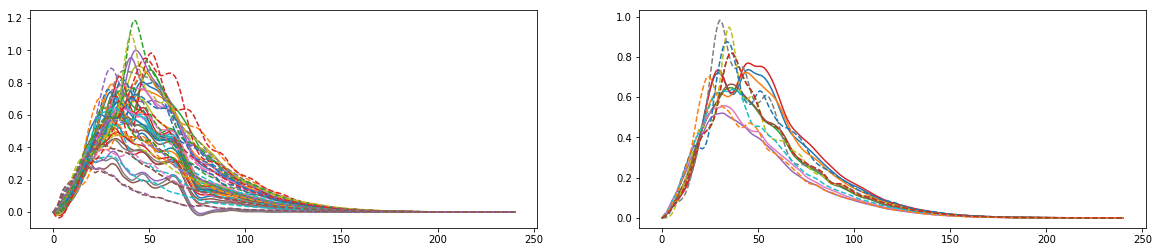

In [145]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred)).T)
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T,'--')
plt.subplot(1,2,2)
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T)
b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T,'--')

Training data - Random Forest


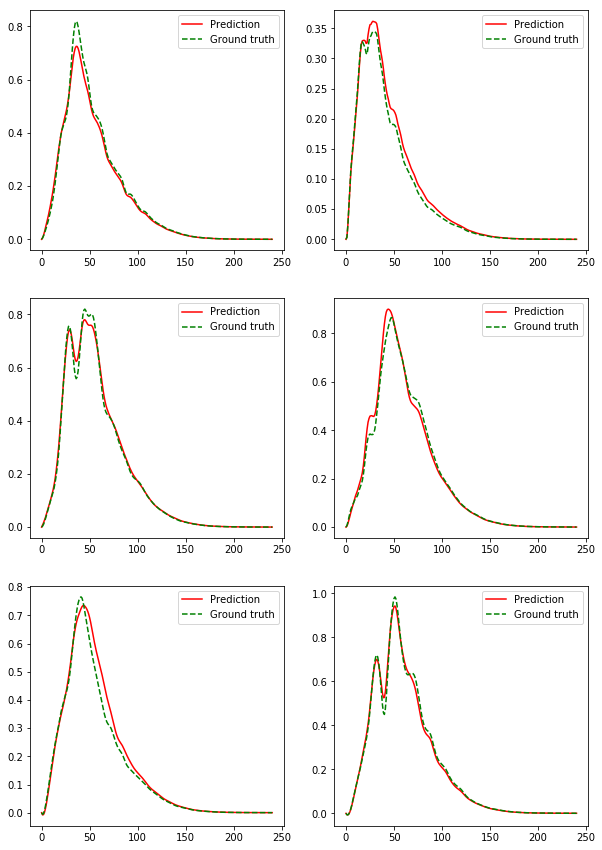

In [146]:
#Train
n=3
plt.figure(figsize=(10,15))
print('Training data - Random Forest')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

Test data - Random Forest


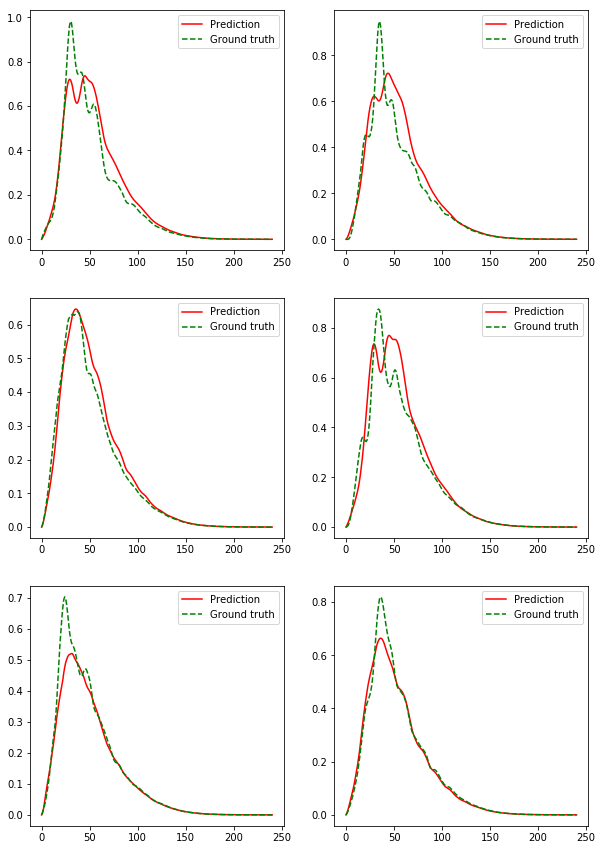

In [147]:
#Test
n=3
plt.figure(figsize=(10,15))
print('Test data - Random Forest')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()

R2 train:0.9204857260578984
R2 test:-1.1648179652365067
RMSE: 0.153413


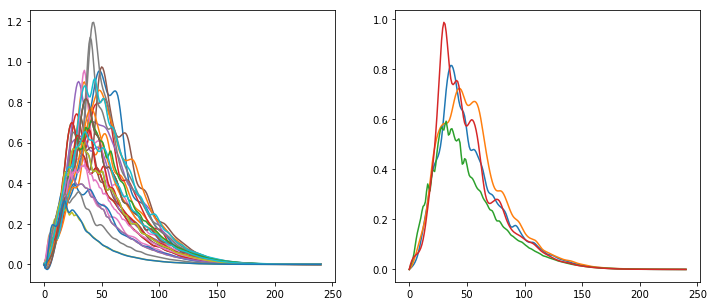

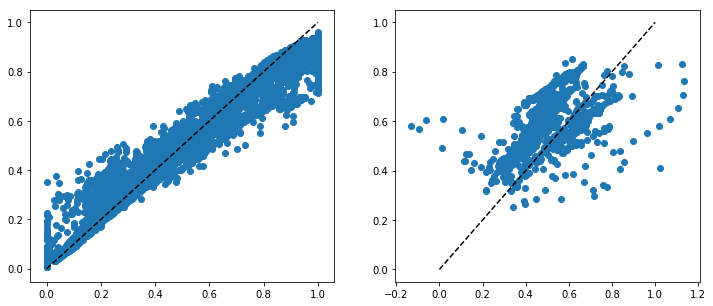

In [30]:
# Random Forest Custom values

X, y = input_data,pca_data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)
[X_test.shape,y_test.shape]

inputs_scaler=MinMaxScaler()

X_train_scaled= inputs_scaler.fit_transform(X_train)
X_test_scaled= inputs_scaler.transform(X_test)


outputs_scaler=MinMaxScaler()

y_train_scaled= outputs_scaler.fit_transform(y_train)
y_test_scaled= outputs_scaler.transform(y_test)


RF_model=RandomForestRegressor()
RF_model.fit(X_train_scaled,y_train_scaled)
print(f'R2 train:{RF_model.score(X_train_scaled,y_train_scaled)}')


preds = RF_model.predict(X_test_scaled)
print(f'R2 test:{RF_model.score(X_test_scaled,y_test_scaled)}')
rmse = np.sqrt(mean_squared_error(y_test_scaled, preds))
print("RMSE: %f" % (rmse))


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_train.T)
plt.subplot(1,2,2)
plt.plot(y_test.T)

lb=np.min(y_train_scaled);ub=np.max(y_train_scaled)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train_scaled,RF_model.predict(X_train_scaled))
plt.plot([lb,ub],[lb,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test_scaled,RF_model.predict(X_test_scaled))
plt.plot([lb,ub],[lb,ub],'k--')

R2 train:0.9998869236823887
R2 test:-2.364874717162886
RMSE: 0.324713


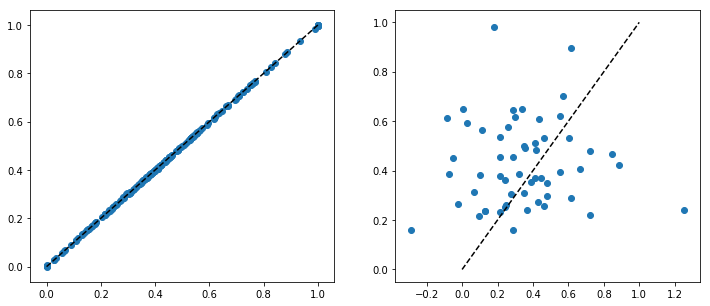

In [148]:
# XGBoost Custom values

XGB_model= MultiOutputRegressor(xgb.XGBRegressor())
XGB_model.fit(X_train_scaled,y_train_scaled)
print(f'R2 train:{XGB_model.score(X_train_scaled,y_train_scaled)}')


preds = XGB_model.predict(X_test_scaled)
print(f'R2 test:{XGB_model.score(X_test_scaled,y_test_scaled)}')
rmse = np.sqrt(mean_squared_error(y_test_scaled, preds))
print("RMSE: %f" % (rmse))

lb=np.min(y_train_scaled);ub=np.max(y_train_scaled)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train_scaled,XGB_model.predict(X_train_scaled))
plt.plot([lb,ub],[lb,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test_scaled,XGB_model.predict(X_test_scaled))
plt.plot([lb,ub],[lb,ub],'k--')

Training data - XBG


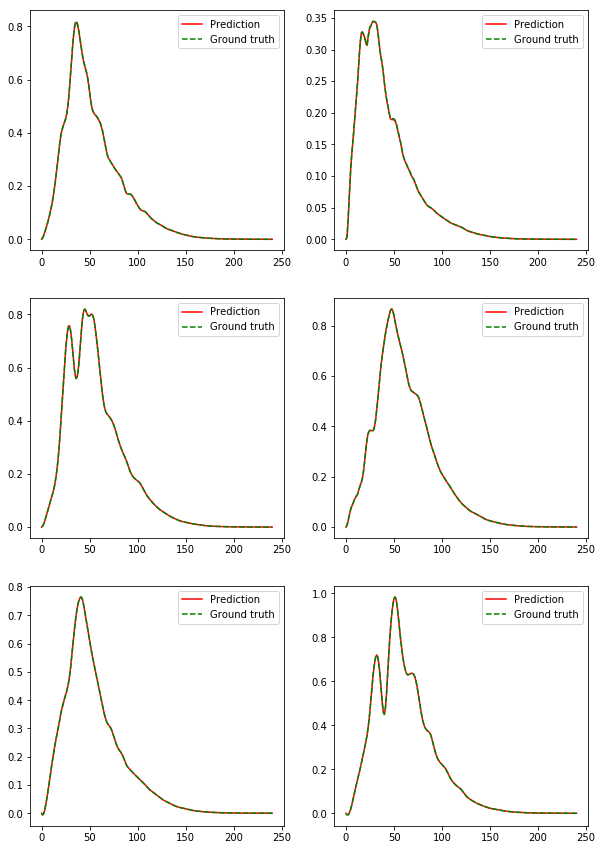

In [149]:
#Train
n=3
pred_train=XGB_model.predict(X_train_scaled)
plt.figure(figsize=(10,15))
print('Training data - XBG')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

Test data - XGB


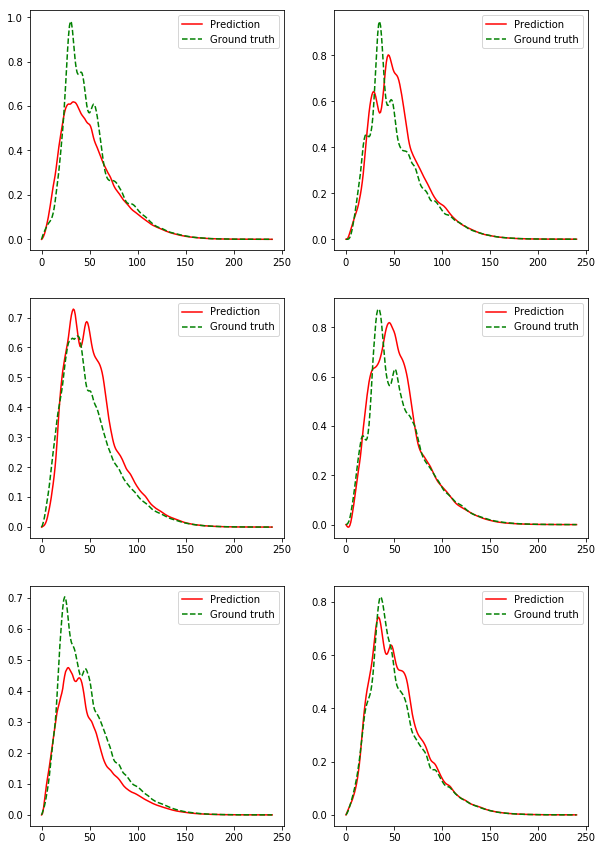

In [150]:
#Test
n=3
pred_test=XGB_model.predict(X_test_scaled)
plt.figure(figsize=(10,15))
print('Test data - XGB')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

In [151]:
# NN Custom values

nn_model = skl_nn.MLPRegressor(
            hidden_layer_sizes=(300,400,300,), alpha=1.e-5, tol=1.e-10, 
            activation='relu', solver='adam', learning_rate='adaptive', 
            max_iter=50000, 
            random_state=12345,verbose=True,n_iter_no_change=100)


nn_model.fit(X_train_scaled,y_train_scaled)

Iteration 1, loss = 0.17835985
Iteration 2, loss = 0.12289765
Iteration 3, loss = 0.08134391
Iteration 4, loss = 0.05212030
Iteration 5, loss = 0.03471443
Iteration 6, loss = 0.02989112
Iteration 7, loss = 0.03378711
Iteration 8, loss = 0.03824287
Iteration 9, loss = 0.03835828
Iteration 10, loss = 0.03495934
Iteration 11, loss = 0.03083718
Iteration 12, loss = 0.02786353
Iteration 13, loss = 0.02646710
Iteration 14, loss = 0.02626634
Iteration 15, loss = 0.02652455
Iteration 16, loss = 0.02668458
Iteration 17, loss = 0.02645684
Iteration 18, loss = 0.02585469
Iteration 19, loss = 0.02500321
Iteration 20, loss = 0.02410074
Iteration 21, loss = 0.02331540
Iteration 22, loss = 0.02274146
Iteration 23, loss = 0.02242085
Iteration 24, loss = 0.02227810
Iteration 25, loss = 0.02219484
Iteration 26, loss = 0.02207429
Iteration 27, loss = 0.02186193
Iteration 28, loss = 0.02156610
Iteration 29, loss = 0.02124576
Iteration 30, loss = 0.02096142
Iteration 31, loss = 0.02074858
Iteration 32, los

Iteration 263, loss = 0.00833923
Iteration 264, loss = 0.00828167
Iteration 265, loss = 0.00823550
Iteration 266, loss = 0.00817498
Iteration 267, loss = 0.00813591
Iteration 268, loss = 0.00808660
Iteration 269, loss = 0.00803723
Iteration 270, loss = 0.00798529
Iteration 271, loss = 0.00793441
Iteration 272, loss = 0.00789082
Iteration 273, loss = 0.00784870
Iteration 274, loss = 0.00779728
Iteration 275, loss = 0.00774643
Iteration 276, loss = 0.00770121
Iteration 277, loss = 0.00766109
Iteration 278, loss = 0.00761458
Iteration 279, loss = 0.00755742
Iteration 280, loss = 0.00751025
Iteration 281, loss = 0.00747294
Iteration 282, loss = 0.00742157
Iteration 283, loss = 0.00737603
Iteration 284, loss = 0.00733048
Iteration 285, loss = 0.00728538
Iteration 286, loss = 0.00723890
Iteration 287, loss = 0.00719326
Iteration 288, loss = 0.00714746
Iteration 289, loss = 0.00710585
Iteration 290, loss = 0.00706465
Iteration 291, loss = 0.00702527
Iteration 292, loss = 0.00697498
Iteration 

Iteration 527, loss = 0.00194695
Iteration 528, loss = 0.00193604
Iteration 529, loss = 0.00190649
Iteration 530, loss = 0.00187270
Iteration 531, loss = 0.00186328
Iteration 532, loss = 0.00185909
Iteration 533, loss = 0.00186234
Iteration 534, loss = 0.00184018
Iteration 535, loss = 0.00182555
Iteration 536, loss = 0.00180644
Iteration 537, loss = 0.00180412
Iteration 538, loss = 0.00180276
Iteration 539, loss = 0.00179942
Iteration 540, loss = 0.00178548
Iteration 541, loss = 0.00176804
Iteration 542, loss = 0.00175119
Iteration 543, loss = 0.00173997
Iteration 544, loss = 0.00172918
Iteration 545, loss = 0.00172272
Iteration 546, loss = 0.00171904
Iteration 547, loss = 0.00170948
Iteration 548, loss = 0.00169893
Iteration 549, loss = 0.00168817
Iteration 550, loss = 0.00167538
Iteration 551, loss = 0.00166206
Iteration 552, loss = 0.00166149
Iteration 553, loss = 0.00165283
Iteration 554, loss = 0.00164702
Iteration 555, loss = 0.00165096
Iteration 556, loss = 0.00165949
Iteration 

Iteration 795, loss = 0.00046499
Iteration 796, loss = 0.00046075
Iteration 797, loss = 0.00045691
Iteration 798, loss = 0.00045138
Iteration 799, loss = 0.00044547
Iteration 800, loss = 0.00044268
Iteration 801, loss = 0.00044283
Iteration 802, loss = 0.00044597
Iteration 803, loss = 0.00045060
Iteration 804, loss = 0.00045460
Iteration 805, loss = 0.00045245
Iteration 806, loss = 0.00044517
Iteration 807, loss = 0.00043555
Iteration 808, loss = 0.00043160
Iteration 809, loss = 0.00042791
Iteration 810, loss = 0.00042665
Iteration 811, loss = 0.00042929
Iteration 812, loss = 0.00043234
Iteration 813, loss = 0.00043427
Iteration 814, loss = 0.00044001
Iteration 815, loss = 0.00044935
Iteration 816, loss = 0.00046175
Iteration 817, loss = 0.00048235
Iteration 818, loss = 0.00050512
Iteration 819, loss = 0.00052780
Iteration 820, loss = 0.00054956
Iteration 821, loss = 0.00055148
Iteration 822, loss = 0.00053438
Iteration 823, loss = 0.00049114
Iteration 824, loss = 0.00044310
Iteration 

Iteration 1058, loss = 0.00023464
Iteration 1059, loss = 0.00023688
Iteration 1060, loss = 0.00023968
Iteration 1061, loss = 0.00024197
Iteration 1062, loss = 0.00024966
Iteration 1063, loss = 0.00025415
Iteration 1064, loss = 0.00026301
Iteration 1065, loss = 0.00026215
Iteration 1066, loss = 0.00025699
Iteration 1067, loss = 0.00024079
Iteration 1068, loss = 0.00022314
Iteration 1069, loss = 0.00021253
Iteration 1070, loss = 0.00020625
Iteration 1071, loss = 0.00020948
Iteration 1072, loss = 0.00021664
Iteration 1073, loss = 0.00022494
Iteration 1074, loss = 0.00022512
Iteration 1075, loss = 0.00022511
Iteration 1076, loss = 0.00022075
Iteration 1077, loss = 0.00021557
Iteration 1078, loss = 0.00021557
Iteration 1079, loss = 0.00021774
Iteration 1080, loss = 0.00022043
Iteration 1081, loss = 0.00022720
Iteration 1082, loss = 0.00023043
Iteration 1083, loss = 0.00023726
Iteration 1084, loss = 0.00023685
Iteration 1085, loss = 0.00022998
Iteration 1086, loss = 0.00022415
Iteration 1087

Iteration 1323, loss = 0.00014976
Iteration 1324, loss = 0.00015001
Iteration 1325, loss = 0.00015057
Iteration 1326, loss = 0.00015321
Iteration 1327, loss = 0.00015610
Iteration 1328, loss = 0.00015827
Iteration 1329, loss = 0.00015868
Iteration 1330, loss = 0.00015754
Iteration 1331, loss = 0.00015477
Iteration 1332, loss = 0.00015080
Iteration 1333, loss = 0.00014665
Iteration 1334, loss = 0.00014355
Iteration 1335, loss = 0.00014146
Iteration 1336, loss = 0.00014006
Iteration 1337, loss = 0.00013899
Iteration 1338, loss = 0.00013827
Iteration 1339, loss = 0.00013818
Iteration 1340, loss = 0.00013908
Iteration 1341, loss = 0.00014070
Iteration 1342, loss = 0.00014257
Iteration 1343, loss = 0.00014553
Iteration 1344, loss = 0.00014915
Iteration 1345, loss = 0.00015425
Iteration 1346, loss = 0.00015858
Iteration 1347, loss = 0.00016511
Iteration 1348, loss = 0.00017411
Iteration 1349, loss = 0.00018603
Iteration 1350, loss = 0.00019823
Iteration 1351, loss = 0.00021112
Iteration 1352

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(300, 400, 300),
             learning_rate='adaptive', max_iter=50000, n_iter_no_change=100,
             random_state=12345, tol=1e-10, verbose=True)

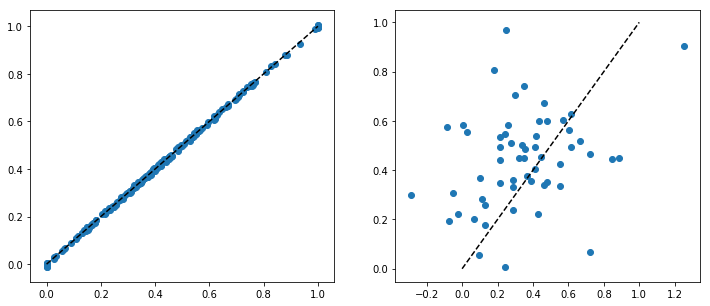

In [152]:
lb=np.min(y_train_scaled);ub=np.max(y_train_scaled)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train_scaled,nn_model.predict(X_train_scaled))
plt.plot([lb,ub],[lb,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test_scaled,nn_model.predict(X_test_scaled))
plt.plot([lb,ub],[lb,ub],'k--')

Training data - Neural Networks


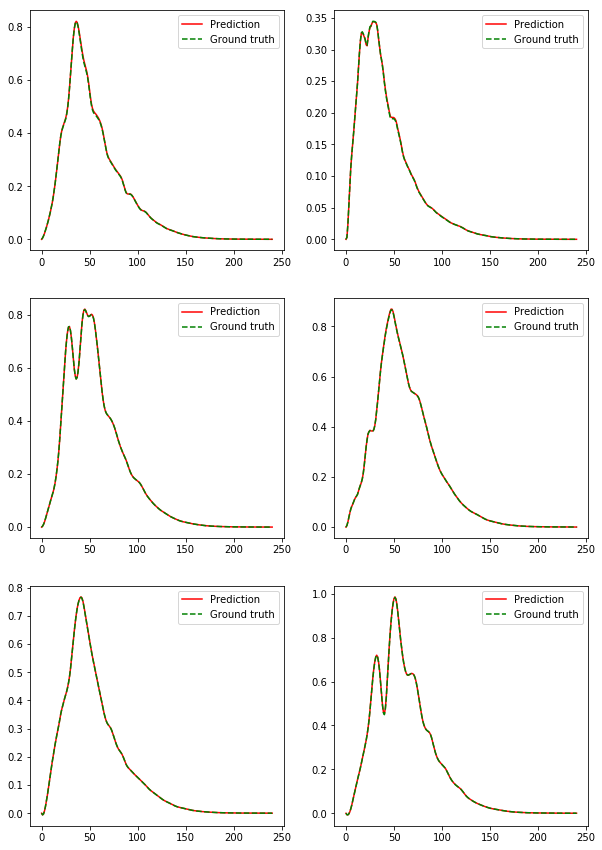

In [153]:
#Train
n=3
pred_train=nn_model.predict(X_train_scaled)
plt.figure(figsize=(10,15))
print('Training data - Neural Networks')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

Test data - Neural Networks


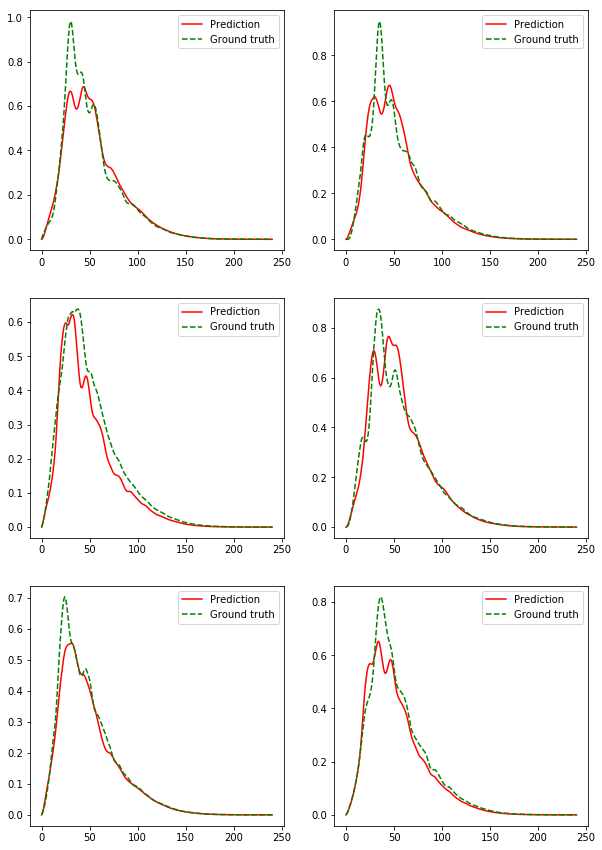

In [154]:
#Test
n=3
pred_test=nn_model.predict(X_test_scaled)
plt.figure(figsize=(10,15))
print('Test data - Neural Networks')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

In [156]:
nn_model = skl_nn.MLPRegressor(
            hidden_layer_sizes=(1000,1000,1000,), alpha=1.e-5, tol=1.e-10, 
            activation='relu', solver='adam', learning_rate='adaptive', 
            max_iter=50000, 
            random_state=12345,verbose=True,n_iter_no_change=100)


nn_model.fit(X_train_scaled,y_train_scaled)

Iteration 1, loss = 0.11782212
Iteration 2, loss = 0.04426079
Iteration 3, loss = 0.02821117
Iteration 4, loss = 0.04204185
Iteration 5, loss = 0.03201732
Iteration 6, loss = 0.02471650
Iteration 7, loss = 0.02548024
Iteration 8, loss = 0.02752278
Iteration 9, loss = 0.02742047
Iteration 10, loss = 0.02548728
Iteration 11, loss = 0.02321969
Iteration 12, loss = 0.02181100
Iteration 13, loss = 0.02156807
Iteration 14, loss = 0.02187265
Iteration 15, loss = 0.02189724
Iteration 16, loss = 0.02142174
Iteration 17, loss = 0.02072874
Iteration 18, loss = 0.02016870
Iteration 19, loss = 0.01991499
Iteration 20, loss = 0.01988881
Iteration 21, loss = 0.01982061
Iteration 22, loss = 0.01958905
Iteration 23, loss = 0.01921877
Iteration 24, loss = 0.01878881
Iteration 25, loss = 0.01844597
Iteration 26, loss = 0.01826902
Iteration 27, loss = 0.01818760
Iteration 28, loss = 0.01807181
Iteration 29, loss = 0.01785270
Iteration 30, loss = 0.01755843
Iteration 31, loss = 0.01728229
Iteration 32, los

Iteration 253, loss = 0.00184544
Iteration 254, loss = 0.00168289
Iteration 255, loss = 0.00164230
Iteration 256, loss = 0.00167886
Iteration 257, loss = 0.00168922
Iteration 258, loss = 0.00165430
Iteration 259, loss = 0.00167139
Iteration 260, loss = 0.00180547
Iteration 261, loss = 0.00185165
Iteration 262, loss = 0.00176909
Iteration 263, loss = 0.00172722
Iteration 264, loss = 0.00165702
Iteration 265, loss = 0.00152258
Iteration 266, loss = 0.00141734
Iteration 267, loss = 0.00143779
Iteration 268, loss = 0.00150604
Iteration 269, loss = 0.00150609
Iteration 270, loss = 0.00142684
Iteration 271, loss = 0.00132026
Iteration 272, loss = 0.00135367
Iteration 273, loss = 0.00144680
Iteration 274, loss = 0.00141446
Iteration 275, loss = 0.00135575
Iteration 276, loss = 0.00134321
Iteration 277, loss = 0.00130880
Iteration 278, loss = 0.00127426
Iteration 279, loss = 0.00122633
Iteration 280, loss = 0.00119951
Iteration 281, loss = 0.00119258
Iteration 282, loss = 0.00118024
Iteration 

Iteration 505, loss = 0.00049149
Iteration 506, loss = 0.00048502
Iteration 507, loss = 0.00048141
Iteration 508, loss = 0.00047841
Iteration 509, loss = 0.00047913
Iteration 510, loss = 0.00047913
Iteration 511, loss = 0.00047759
Iteration 512, loss = 0.00047909
Iteration 513, loss = 0.00048481
Iteration 514, loss = 0.00050210
Iteration 515, loss = 0.00053514
Iteration 516, loss = 0.00059592
Iteration 517, loss = 0.00070713
Iteration 518, loss = 0.00088843
Iteration 519, loss = 0.00117782
Iteration 520, loss = 0.00140413
Iteration 521, loss = 0.00142043
Iteration 522, loss = 0.00098489
Iteration 523, loss = 0.00052470
Iteration 524, loss = 0.00059447
Iteration 525, loss = 0.00089652
Iteration 526, loss = 0.00084530
Iteration 527, loss = 0.00053789
Iteration 528, loss = 0.00054590
Iteration 529, loss = 0.00074481
Iteration 530, loss = 0.00067146
Iteration 531, loss = 0.00048981
Iteration 532, loss = 0.00055238
Iteration 533, loss = 0.00065328
Iteration 534, loss = 0.00054868
Iteration 

Iteration 754, loss = 0.00074280
Iteration 755, loss = 0.00053691
Iteration 756, loss = 0.00031816
Iteration 757, loss = 0.00027677
Iteration 758, loss = 0.00039696
Iteration 759, loss = 0.00049519
Iteration 760, loss = 0.00044470
Iteration 761, loss = 0.00031341
Iteration 762, loss = 0.00026508
Iteration 763, loss = 0.00033367
Iteration 764, loss = 0.00040014
Iteration 765, loss = 0.00036948
Iteration 766, loss = 0.00028938
Iteration 767, loss = 0.00026071
Iteration 768, loss = 0.00030277
Iteration 769, loss = 0.00033634
Iteration 770, loss = 0.00030665
Iteration 771, loss = 0.00026129
Iteration 772, loss = 0.00026528
Iteration 773, loss = 0.00030059
Iteration 774, loss = 0.00030970
Iteration 775, loss = 0.00028291
Iteration 776, loss = 0.00025605
Iteration 777, loss = 0.00026076
Iteration 778, loss = 0.00028116
Iteration 779, loss = 0.00028480
Iteration 780, loss = 0.00026582
Iteration 781, loss = 0.00025234
Iteration 782, loss = 0.00025996
Iteration 783, loss = 0.00027233
Iteration 

Iteration 1006, loss = 0.00024312
Iteration 1007, loss = 0.00024310
Iteration 1008, loss = 0.00024307
Iteration 1009, loss = 0.00024305
Iteration 1010, loss = 0.00024303
Iteration 1011, loss = 0.00024301
Iteration 1012, loss = 0.00024299
Iteration 1013, loss = 0.00024296
Iteration 1014, loss = 0.00024294
Iteration 1015, loss = 0.00024292
Iteration 1016, loss = 0.00024290
Iteration 1017, loss = 0.00024288
Iteration 1018, loss = 0.00024286
Iteration 1019, loss = 0.00024284
Iteration 1020, loss = 0.00024282
Iteration 1021, loss = 0.00024280
Iteration 1022, loss = 0.00024278
Iteration 1023, loss = 0.00024277
Iteration 1024, loss = 0.00024276
Iteration 1025, loss = 0.00024276
Iteration 1026, loss = 0.00024277
Iteration 1027, loss = 0.00024280
Iteration 1028, loss = 0.00024285
Iteration 1029, loss = 0.00024292
Iteration 1030, loss = 0.00024301
Iteration 1031, loss = 0.00024312
Iteration 1032, loss = 0.00024325
Iteration 1033, loss = 0.00024335
Iteration 1034, loss = 0.00024344
Iteration 1035

Iteration 1250, loss = 0.00023858
Iteration 1251, loss = 0.00023856
Iteration 1252, loss = 0.00023854
Iteration 1253, loss = 0.00023852
Iteration 1254, loss = 0.00023849
Iteration 1255, loss = 0.00023847
Iteration 1256, loss = 0.00023845
Iteration 1257, loss = 0.00023843
Iteration 1258, loss = 0.00023841
Iteration 1259, loss = 0.00023839
Iteration 1260, loss = 0.00023837
Iteration 1261, loss = 0.00023835
Iteration 1262, loss = 0.00023833
Iteration 1263, loss = 0.00023830
Iteration 1264, loss = 0.00023828
Iteration 1265, loss = 0.00023826
Iteration 1266, loss = 0.00023824
Iteration 1267, loss = 0.00023822
Iteration 1268, loss = 0.00023820
Iteration 1269, loss = 0.00023818
Iteration 1270, loss = 0.00023816
Iteration 1271, loss = 0.00023814
Iteration 1272, loss = 0.00023813
Iteration 1273, loss = 0.00023811
Iteration 1274, loss = 0.00023810
Iteration 1275, loss = 0.00023810
Iteration 1276, loss = 0.00023811
Iteration 1277, loss = 0.00023815
Iteration 1278, loss = 0.00023822
Iteration 1279

Iteration 1493, loss = 0.00023461
Iteration 1494, loss = 0.00023460
Iteration 1495, loss = 0.00023459
Iteration 1496, loss = 0.00023457
Iteration 1497, loss = 0.00023453
Iteration 1498, loss = 0.00023450
Iteration 1499, loss = 0.00023448
Iteration 1500, loss = 0.00023447
Iteration 1501, loss = 0.00023446
Iteration 1502, loss = 0.00023443
Iteration 1503, loss = 0.00023440
Iteration 1504, loss = 0.00023438
Iteration 1505, loss = 0.00023436
Iteration 1506, loss = 0.00023434
Iteration 1507, loss = 0.00023432
Iteration 1508, loss = 0.00023430
Iteration 1509, loss = 0.00023427
Iteration 1510, loss = 0.00023425
Iteration 1511, loss = 0.00023423
Iteration 1512, loss = 0.00023421
Iteration 1513, loss = 0.00023419
Iteration 1514, loss = 0.00023417
Iteration 1515, loss = 0.00023414
Iteration 1516, loss = 0.00023412
Iteration 1517, loss = 0.00023410
Iteration 1518, loss = 0.00023408
Iteration 1519, loss = 0.00023406
Iteration 1520, loss = 0.00023404
Iteration 1521, loss = 0.00023402
Iteration 1522

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(1000, 1000, 1000),
             learning_rate='adaptive', max_iter=50000, n_iter_no_change=100,
             random_state=12345, tol=1e-10, verbose=True)

Training data - Neural Networks


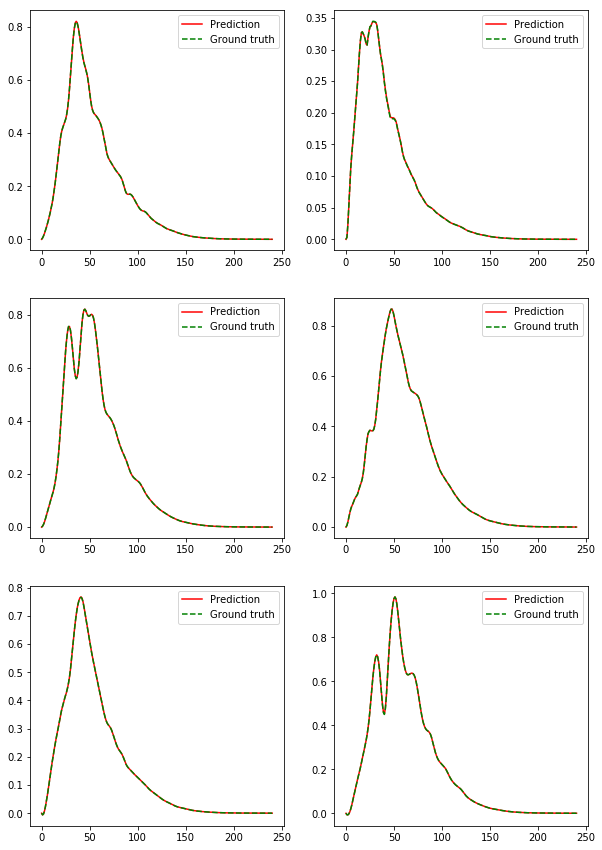

In [157]:
#Train
n=3
pred_train=nn_model.predict(X_train_scaled)
plt.figure(figsize=(10,15))
print('Training data - Neural Networks')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_train)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_train_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

Test data - Neural Networks


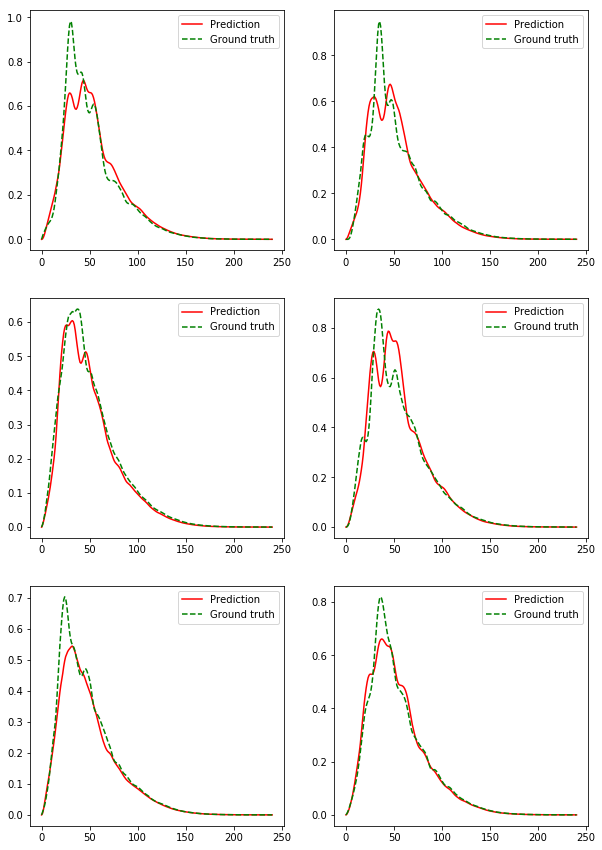

In [158]:
#Test
n=3
pred_test=nn_model.predict(X_test_scaled)
plt.figure(figsize=(10,15))
print('Test data - Neural Networks')
for i in range(2*n):
    plt.subplot(n,2,i+1)
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(pred_test)).T[:,i],'r',label='Prediction')
    b=plt.plot(pca_reductor.inverse_transform(outputs_scaler.inverse_transform(y_test_scaled)).T[:,i],'g--',label='Ground truth')
    plt.legend()
plt.show()

In [ ]:
#Grid search

n_estimators = [int(x) for x in np.arange(start = 10, stop = 2000, step = 10)]
max_features = [0.5,'auto', 'sqrt','log2']
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# First create the base model to tune
RF_model = RandomForestRegressor()
# Fit the random search model
RF_model_random = RandomizedSearchCV(estimator = RF_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
RF_model_random.fit(X_train, y_train)
RF_model_random.best_params_